In [1]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np                         # Good module for matrix and matrix operation
import matplotlib.pyplot as plt            # Module to produce figure
import matplotlib.colors as colors
import os                                  # Used to convert png to other format
from matplotlib.path import Path
import matplotlib.patches as patches
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import numpy as np

In [2]:
def lambert_map(extent=(-82, -75, 41, 46), cent_lon =-80,figsize=(14, 12), fig = None, ax = None):

    proj = ccrs.LambertConformal(central_longitude=cent_lon, central_latitude=35,
                                 standard_parallels=[35])
    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1, projection=proj)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='None',
                                            #edgecolor='face',
                                            facecolor='1')
    lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='None',
                                            facecolor=[(0.59375 , 0.71484375, 0.8828125)])
    lakes_50m_edge= cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='k',
                                            facecolor='None',lw=0.8)
    ax.add_feature(land_50m);
    #ax.add_feature(lakes_50m, zorder=3); 
    ax.add_feature(lakes_50m_edge, zorder=10,lw=0.6);
    #ax.add_feature(cfeature.LAKES, edgecolor='white', zorder=10);
    ax.add_feature(cfeature.BORDERS, zorder=10,edgecolor='dimgray',lw=0.5);
    #ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    #ax.coastlines('50m', zorder=15, color='k',lw=0.5)
    ax.coastlines('50m', zorder=15, color='k',linewidths=0.6)
    # Set plot bounds
    ax.set_extent(extent)
    return fig, ax

In [3]:
perc = 'p99p0'

percentile = 99

totaltx     = 7305*24

percent_num = int((100.-percentile)/100*(totaltx))


In [6]:
# Topography 

Topo  = netCDF4.Dataset('Geopotential_orography.nc','r')
elevation = Topo.variables['z'][0,:,:]
print(elevation.shape)

# Averaged exceedance 
# ERA5: precipitation & wind speed
TPex=netCDF4.Dataset('Averaged_exceedance_TP_'+perc+'_ERA5.nc','r')
WSex=netCDF4.Dataset('Averaged_exceedance_WS_'+perc+'_ERA5.nc','r')
lat0 = TPex.variables['latitude'][:]
lon0 = TPex.variables['longitude'][:]
TPavgexceed = TPex.variables['Exceedance'][:,:]
WSavgexceed = WSex.variables['Exceedance'][:,:]

# IMERG: precipitation
TPexI=netCDF4.Dataset('Averaged_exceedance_TP_'+perc+'_IMERG.nc','r')
lat0I = TPexI.variables['latitude'][:]
lon0I = TPexI.variables['longitude'][:]
TPavgexceedI = TPexI.variables['Exceedance'][:,:]

(201, 521)


In [7]:
lon, lat = np.meshgrid(lon0, lat0)
print (lat.shape[0])
print (lon.shape[1])

nx= lon.shape[0]
ny= lon.shape[1]
lonI, latI = np.meshgrid(lon0I, lat0I)

201
521


In [10]:
# Extreme information

# ====== ERA5 ====================
# Wind speed
# threshold values
WSthreshold = netCDF4.Dataset('WS'+perc+'_2001_2020_ERA5.nc','r')
WSEXthresh  = WSthreshold.variables[perc][:,:]

# extremes associated with ETCs 
WSETC =netCDF4.Dataset('WSExtremes_'+perc+'_ETC_association_2001_2020_ERA5.nc','r')
# seasonal value
WSEXETCvalues_sea = WSETC.variables['Extremevalues_ETC_sea'][:,:,:] #cumulated extreme values in each season 
WSEXcases_sea     = WSETC.variables['Extreme_cases_sea'][:,:,:] #number of hourly extremes in each season
# annual value 
WSEXETCvalues = np.nansum(WSEXETCvalues_sea, axis=0)
WSEXcases     = np.nansum(WSEXcases_sea, axis=0)
WSProbETC     = WSETC.variables['Prob_Extreme_ass_ETC'][:,:]
WSEXETCcases  = WSProbETC*WSEXcases
WSEXNOETCcases = WSEXETCcases*-1+percent_num

WSavgETCExceedance     = (WSEXETCvalues[:,:]-WSEXthresh[:,:]*WSEXETCcases[:,:])/WSEXETCcases[:,:]
WSavgNOETCExceedance   = (WSavgexceed*percent_num - WSavgETCExceedance*WSEXETCcases)/WSEXNOETCcases

# Hourly precipitation
# threshold values
TPthreshold = netCDF4.Dataset('TP'+perc+'_2001_2020_ERA5.nc','r')
TPEXthresh  = TPthreshold.variables[perc][:,:]

# extremes associated with ETCs 
TPETC =netCDF4.Dataset('TPExtremes_'+perc+'_ETC_association_2001_2020_ERA5.nc','r')
# seasonal value 
TPEXETCvalues_sea = TPETC.variables['Extremevalues_ETC_sea'][:,:,:]
TPEXcases_sea     = TPETC.variables['Extreme_cases_sea'][:,:,:]
# annual value 
TPEXETCvalues = np.nansum(TPEXETCvalues_sea, axis=0)
TPEXcases     = np.nansum(TPEXcases_sea, axis=0)
TPProbETC     = TPETC.variables['Prob_Extreme_ass_ETC'][:,:]
TPEXETCcases  = TPProbETC*TPEXcases
TPEXNOETCcases  = TPEXETCcases*-1+percent_num

TPavgETCExceedance     = (TPEXETCvalues[:,:]-TPEXthresh[:,:]*TPEXETCcases[:,:])/TPEXETCcases[:,:]
TPavgNOETCExceedance   = (TPavgexceed*percent_num - TPavgETCExceedance*TPEXETCcases)/TPEXNOETCcases

# ====== IMERG ====================
# ORIGINAL FINER GRID ---------
ITPthreshold = netCDF4.Dataset('TP'+perc+'_2001_2020_IMERG.nc','r')
ITPEXthresh  = ITPthreshold.variables[perc][:,:]
# extremes associated with ETCs 
ITPETC =netCDF4.Dataset('TPExtremes_'+perc+'_ETC_association_2001_2020_IMERG.nc','r')
# seasonal value
ITPEXETCvalues_sea = ITPETC.variables['Extremevalues_ETC_sea'][:,:,:]
ITPEXcases_sea     = ITPETC.variables['Extreme_cases_sea'][:,:,:]
# annual value 
ITPEXETCvalues = np.nansum(ITPEXETCvalues_sea, axis=0)
ITPEXcases     = np.nansum(ITPEXcases_sea, axis=0)
ITPProbETC     = ITPETC.variables['Prob_Extreme_ass_ETC'][:,:]
ITPEXETCcases  = ITPProbETC*ITPEXcases
ITPEXNOETCcases  = ITPEXETCcases*-1+percent_num

ITPavgETCExceedance     = (ITPEXETCvalues[:,:]-ITPEXthresh[:,:]*ITPEXETCcases[:,:])/ITPEXETCcases[:,:]
ITPavgNOETCExceedance   = (TPavgexceedI*percent_num - ITPavgETCExceedance*ITPEXETCcases)/ITPEXNOETCcases

# REGRIDDED TO ERA5 GRID ---------
ITPthreshold025 = netCDF4.Dataset('TP'+perc+'_2001_2020_IMERG025grid.nc','r')
ITPEXthresh025  = ITPthreshold025.variables[perc][:,:]
lat0I25 = ITPthreshold025.variables['lat'][:]
lon0I25 = ITPthreshold025.variables['lon'][:]
lonI25, latI25 = np.meshgrid(lon0I25, lat0I25)

In [11]:
# To show the extreme threshold difference of IMERG (regridded to the same ERA5 grid) minus ERA5:

DIFF = np.full_like(ITPEXthresh025, np.nan)
for j in range(lat0I25.shape[0]-1,-1,-1):
    #print('j=',j,'latI=',lat0I25[j],'latE=',lat0[j+60])
    for i in range(lon0I25.shape[0]):
        #print('i=',i,'lonI=',lon0I25[i],'lonE=',lon0[i])
        DIFF[j,i]= ITPEXthresh025[j,i]-TPEXthresh[j+60,i]

In [13]:
# VERIFICATION 
# ====== ISD ====================
ISDthreshold = netCDF4.Dataset('WSnTP'+perc+'_exthreshold_ISD.nc4','r')
TPEXthreshISD  = ISDthreshold.variables['pr'][:]
WSEXthreshISD  = ISDthreshold.variables['sfcWind'][:]
lat0ISD = ISDthreshold.variables['lat'][:]
lon0ISD = ISDthreshold.variables['lon'][:]

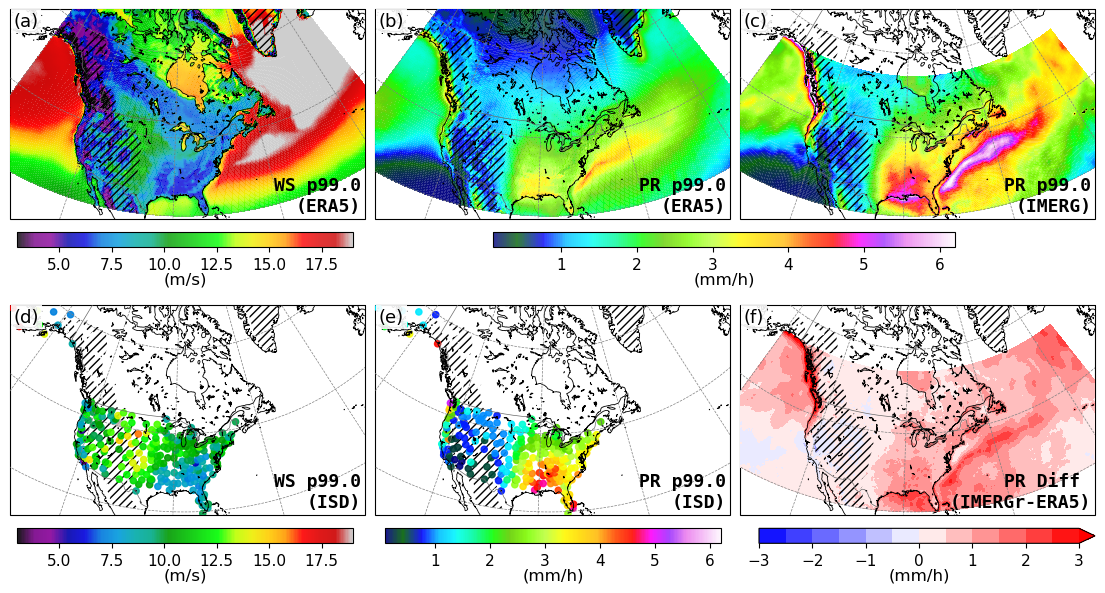

In [14]:
import scipy.ndimage
mono_font = {'fontname':'monospace'}
sans_font = {'fontname':'sans-serif'}
cmap=plt.cm.get_cmap('gist_ncar')
cmap2=plt.cm.get_cmap('nipy_spectral')
fig = plt.figure(figsize=(14,7.5))
proj = ccrs.LambertConformal(central_longitude=-87, central_latitude=35,
                                 standard_parallels=[35])

    
ax = fig.add_subplot(2, 3, 1, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
#cf = ax.contourf(lon, lat, avgExceedance[:,:], levels, transform=ccrs.PlateCarree(), zorder=6,
#                 cmap=plt.cm.get_cmap('Spectral_r'),extend='both')
cf = ax.pcolormesh(lon, lat, WSEXthresh[:,:], #vmin=2, vmax=32,
                   vmin=3, vmax=19,
                   transform=ccrs.PlateCarree(), zorder=6,alpha=0.8,
                   cmap=cmap2)

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

# position for the colorbar
cbaxes = fig.add_axes([0.13, 0.515, 0.24, 0.02])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=11)
#cb.ax.set_title('(m/s)', x=1.12, y=-1.8, fontsize=10)
cb.ax.set_title('(m/s)',fontsize=12, y=-3)
ax.text(0.99,0.02,'WS p99.0\n(ERA5)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')

ax.text(0.01,0.985,'(a)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

#-------------------------------------
ax = fig.add_subplot(2, 3, 2, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)

cf = ax.pcolormesh(lon, lat, TPEXthresh[:,:], #vmin=0.1, vmax=15.5,
                   vmin=0.1, vmax=6.2,
                   transform=ccrs.PlateCarree(), zorder=6,alpha=0.8,
                   cmap=cmap)

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

# position for the colorbar
cbaxes = fig.add_axes([0.47, 0.515, 0.33, 0.02])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=11)
cb.ax.set_title('(mm/h)', fontsize=12, y=-3)
ax.text(0.99,0.02,'PR p99.0\n(ERA5)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(b)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

#-------------------------------------
 
ax = fig.add_subplot(2, 3, 3, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)

cf = ax.pcolormesh(lonI, latI, ITPEXthresh[:,:], vmin=0.1, vmax=6.2,
                   transform=ccrs.PlateCarree(), zorder=6, alpha=0.8,
                   cmap=cmap)

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)
ax.text(0.99,0.02,'PR p99.0\n(IMERG)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(c)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

#-------------------------------------
 
ax = fig.add_subplot(2, 3, 4, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)

cf = plt.scatter(lon0ISD, lat0ISD, c=WSEXthreshISD, vmin=3,vmax=19,s=20,alpha=0.9,
                 cmap=cmap2, transform=ccrs.PlateCarree(),zorder=9)

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=8)
ax.text(0.99,0.02,'WS p99.0\n(ISD)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(d)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

cbaxes = fig.add_axes([0.13, 0.12, 0.24, 0.02])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=11)

cb.ax.set_title('(m/s)',fontsize=12, y=-3)

#-------------------------------------
 
ax = fig.add_subplot(2, 3, 5, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)

cf = plt.scatter(lon0ISD, lat0ISD, c=TPEXthreshISD, vmin=0.1, vmax=6.2,s=20, alpha=0.9,
                 cmap=cmap, transform=ccrs.PlateCarree(),zorder=9)

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=8)
ax.text(0.99,0.02,'PR p99.0\n(ISD)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(e)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

cbaxes = fig.add_axes([0.393, 0.12, 0.24, 0.02])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=11)

cb.ax.set_title('(mm/h)',fontsize=12, y=-3)
#===================================

ax = fig.add_subplot(2, 3, 6, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)

cf4 = ax.contourf(lonI25, latI25, DIFF[:,:], levels=np.arange(-3,3.5,0.5),
                   transform=ccrs.PlateCarree(), zorder=6,
                   cmap=plt.cm.get_cmap('bwr'),extend='max')

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

ax.text(0.99,0.02,'PR Diff \n(IMERGr-ERA5)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(f)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)


gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

cbaxes = fig.add_axes([0.66, 0.12, 0.24, 0.02])  
cb = plt.colorbar(cf4, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=11)

cb.ax.set_title('(mm/h)',fontsize=12, y=-3)
#===================================
plt.subplots_adjust(wspace=0.03, hspace=0.05)
plt.savefig('Fig1_Exthreshold_pr'+perc+'_ISDincluded', bbox_inches='tight', dpi=200)
plt.show()
#plt.close()

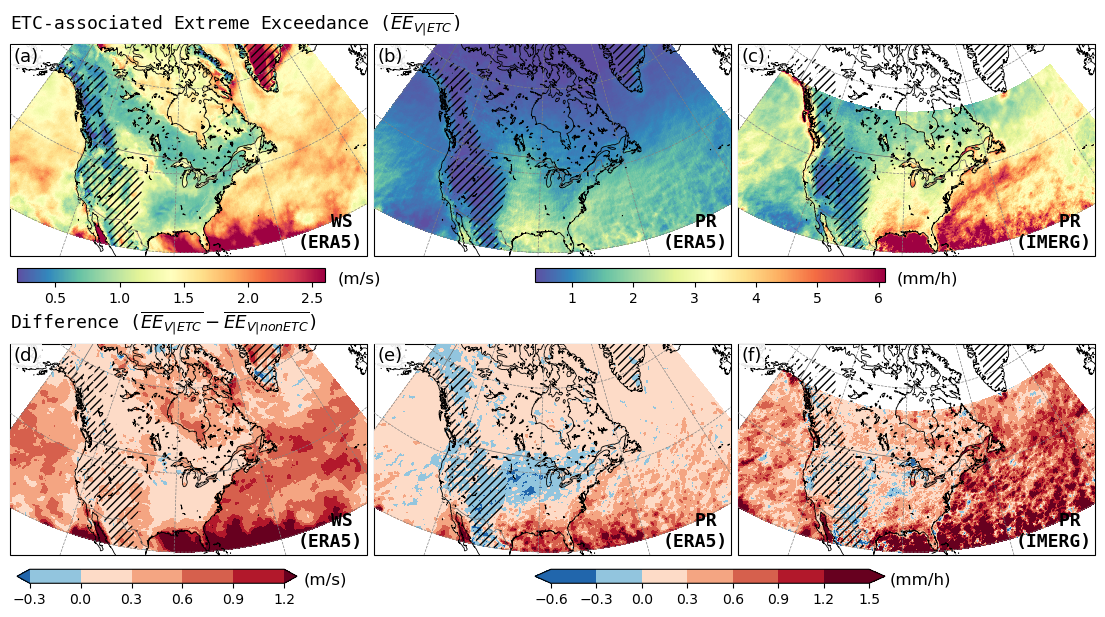

In [15]:
import scipy.ndimage
mono_font = {'fontname':'monospace'}
sans_font = {'fontname':'sans-serif'}

fig = plt.figure(figsize=(14,7))
proj = ccrs.LambertConformal(central_longitude=-87, central_latitude=35,
                                 standard_parallels=[35])


if perc == 'p99p9':
    vmaxws=6
    vmaxpr=10
    levelsd=np.arange(-0.4,1.0,0.2)
    levelsd2=np.arange(-0.8,2.4,0.4)
    
elif perc == 'p99p0' or perc=='p98p0':
    vmaxws=2.6
    #vmaxpr=5.4
    vmaxpr=6.1
    levelsd=np.arange(-0.3,1.5,0.3)
    levelsd2=np.arange(-0.6,1.8,0.3)
    
ax = fig.add_subplot(2, 3, 1, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
#cf = ax.contourf(lon, lat, avgExceedance[:,:], levels, transform=ccrs.PlateCarree(), zorder=6,
#                 cmap=plt.cm.get_cmap('Spectral_r'),extend='both')
cf = ax.pcolormesh(lon, lat, WSavgETCExceedance[:,:], vmin=0.2, vmax=vmaxws,
                   transform=ccrs.PlateCarree(), zorder=6,
                   cmap=plt.cm.get_cmap('Spectral_r'))

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

# position for the colorbar
cbaxes = fig.add_axes([0.13, 0.52, 0.22, 0.02])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=10)
cb.ax.set_title('(m/s)', x=1.11, y=-0.7, fontsize=12)
ax.text(0.99,0.02,'WS \n(ERA5)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')

ax.text(0.01,0.985,'(a)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)
ax.text(0.,1.03,'ETC-associated Extreme Exceedance ('r'$\overline{EE_{V|ETC}}$)',horizontalalignment='left',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font)

ax = fig.add_subplot(2, 3, 2, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)

cf = ax.pcolormesh(lon, lat, TPavgETCExceedance[:,:], vmin=0.4, vmax=vmaxpr,
                   transform=ccrs.PlateCarree(), zorder=6,
                   cmap=plt.cm.get_cmap('Spectral_r'))

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

# position for the colorbar
cbaxes = fig.add_axes([0.5, 0.52, 0.25, 0.02])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=10)
cb.ax.set_title('(mm/h)', x=1.12, y=-0.7, fontsize=12)
ax.text(0.99,0.02,'PR \n(ERA5)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(b)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

 
ax = fig.add_subplot(2, 3, 3, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
#cf = ax.contourf(lon, lat, avgExceedance[:,:], levels, transform=ccrs.PlateCarree(), zorder=6,
#                 cmap=plt.cm.get_cmap('Spectral_r'),extend='both')
cf = ax.pcolormesh(lonI, latI, ITPavgETCExceedance[:,:], vmin=0.4, vmax=vmaxpr,
                   transform=ccrs.PlateCarree(), zorder=6,
                   cmap=plt.cm.get_cmap('Spectral_r'))

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)
ax.text(0.99,0.02,'PR \n(IMERG)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(c)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

#====== ETC associateion ===========================



colors=['#2166ac', '#92c5de', '#fddbc7', '#f4a582','#d6604d','#b2182b','#67001f']

ax = fig.add_subplot(2, 3, 4, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)

cfd = ax.contourf(lon, lat, WSavgETCExceedance-WSavgNOETCExceedance, levelsd,  extend='both',
                   transform=ccrs.PlateCarree(), zorder=6,
                   colors=colors)

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)
gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

# position for the colorbar
cbaxes = fig.add_axes([0.13, 0.09, 0.2, 0.02])  
cb = plt.colorbar(cfd, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=10)
cb.ax.set_title('(m/s)', x=1.16, y=-0.7, fontsize=12)
ax.text(0.99,0.02,'WS \n(ERA5)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')

ax.text(0.01,0.985,'(d)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

ax.text(0.,1.03,'Difference ('r'$\overline{EE_{V|ETC}}-\overline{EE_{V|nonETC}}$)',horizontalalignment='left',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font)
#---------------------------------------------------
ax = fig.add_subplot(2, 3, 5, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
#cf = ax.contourf(lon, lat, avgExceedance[:,:], levels, transform=ccrs.PlateCarree(), zorder=6,
#                 cmap=plt.cm.get_cmap('Spectral_r'),extend='both')
cfd = ax.contourf(lon, lat, TPavgETCExceedance-TPavgNOETCExceedance, levelsd2, extend='both',
                   transform=ccrs.PlateCarree(), zorder=6,
                    colors=colors)

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

# position for the colorbar
cbaxes = fig.add_axes([0.5, 0.09, 0.25, 0.02])  
cb = plt.colorbar(cfd, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=10)
cb.ax.set_title('(mm/h)', x=1.16, y=-0.7, fontsize=12)
ax.text(0.99,0.02,'PR \n(ERA5)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(e)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

#---------------------------------------------------
ax = fig.add_subplot(2, 3, 6, projection=proj)
fig, ax = lambert_map(extent=(-133, -39, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
cfd = ax.contourf(lonI, latI, ITPavgETCExceedance-ITPavgNOETCExceedance, levelsd2, extend='both',
                   transform=ccrs.PlateCarree(), zorder=6,
                    colors=colors)
gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)
ax.text(0.99,0.02,'PR \n(IMERG)',horizontalalignment='right',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')
ax.text(0.01,0.985,'(f)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)
gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

#===================================
plt.subplots_adjust(wspace=0.02, hspace=0.25)
plt.savefig('Fig6_Exceedance_pr'+perc+'_all_ETCasssociatedornot', bbox_inches='tight', dpi=200)
plt.show()
#plt.close()